## Replicate - DeepLOB: Deep Convolutional Neural Networks for Limit Order Books
(Paper authors: Zihao Zhang, Stefan Zohren, Stephen Roberts)

Dataset source: https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, concatenate, LSTM, Reshape, Dense
from keras.callbacks import EarlyStopping

from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

def cdRootDir():
    cur_dir = os.getcwd()
    while cur_dir is not '/':
        os.chdir('../')
        cur_dir = os.getcwd()

# file_path = file_name
def writeJsonFile(file_path, json_string):
    # write to a json file
    # Directly from dictionary
    cdRootDir()
    with open(file_path, 'w') as outfile:
        json.dump(json_string, outfile)

# read;
def readJsonFile(file_path):
    # read form a json file
    cdRootDir()
    with open(file_path) as json_file:
        data = json.load(json_file)
        return data

# increasing ordered by name
def getAllFileNames(folder_path) -> list:
    cdRootDir()
    data_filenames : object  = os.scandir(folder_path)
    data_filename_list : list = []
    for entry in data_filenames:
        if (entry.is_file()):
            data_filename_list.append(entry.name)
    data_filename_list.sort()
    return data_filename_list

def prevDay(cur_time : str, n : int):
    from datetime import datetime
    cur_datetime = datetime.strptime(cur_time[:10], ("%Y-%m-%d"))
    return_datetime = cur_datetime - datetime.timedelta(days=n)
    return (return_datetime.strftime("%Y-%m-%d"))


Mounted at /content/drive


In [ ]:
# # set random seed

# from tensorflow import set_random_seed
# set_random_seed(10)

# Data preparation

The first 40 columns of the FI-2010 dataset are 10 levels ask and bid information for a limit order book and we only use these 40 features in our network. The last 5 columns of the FI-2010 dataset are the labels with different prediction horizons. 

In [ ]:
data_file = open('/content/drive/MyDrive/IE421/IEX_DATA/data_300000.npy', 'rb')
labels_file = open('/content/drive/MyDrive/IE421/IEX_DATA/labels_300000.npy', 'rb')

# x_a = np.load(data_file, allow_pickle=True)
# x_b = np.load(data_file, allow_pickle=True)
x_c = np.load(data_file, allow_pickle=True)
x_d = np.load(data_file, allow_pickle=True)

# l_a = np.load(labels_file, allow_pickle=True)
# l_b = np.load(labels_file, allow_pickle=True)
l_c = np.load(labels_file, allow_pickle=True)
l_d = np.load(labels_file, allow_pickle=True)


x = (np.concatenate((x_c, x_d), axis=0))
y = (np.concatenate((l_c, l_d), axis=0))

del x_c
del x_d
del l_c
del l_d

# test_fi_1 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_6.txt')
# test_fi_2 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_7.txt')
# test_fi_3 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_8.txt')
# test_fi_4 = np.loadtxt('./data/Test_Dst_NoAuction_DecPre_CF_9.txt')
# test_fi = np.hstack((test_fi_1, test_fi_2, test_fi_3,test_fi_4))

In [ ]:
y = np_utils.to_categorical(y, 3)

train_x = x[:10000]
train_y = y[:10000]
test_x = x[10000:]
test_y = y[10000:]

In [ ]:
# print(type(train_x[0][0][0]))
# for i in range(len(train_x)):

# train_x[0][0][0] = train_x[0][0][0].astype(np.float32)
# train_y.astype(np.float32)
# test_x.astype(np.float32)
# test_y.astype(np.float32)

# print(type(train_x[0][0][0]))

print(train_x.shape)
print(test_y.shape)

In [ ]:
# def extract_x_y_data(data, timestamp_per_sample):
#     data_x = np.array(data[:40, :].T)
#     data_y = np.array(data[-5:, :].T)
#     [N, P_x] = data_x.shape
# #     P_y = data_y.shape[1]
    
#     x = np.zeros([(N-timestamp_per_sample+1), timestamp_per_sample, P_x]) # [N-100+1, 100, 40]
    
#     for i in range(N-timestamp_per_sample+1):
#         x[i] = data_x[i:(i+timestamp_per_sample), :]
        
#     x = x.reshape(x.shape + (1,))
        
#     y = data_y[(timestamp_per_sample-1):]
#     y = y[:,3] - 1
#     y = np_utils.to_categorical(y, 3)
    
#     return x, y

# train_fi_x, train_fi_y = extract_x_y_data(train_fi, timestamp_per_sample=100)
# test_fi_x, test_fi_y = extract_x_y_data(test_fi, timestamp_per_sample=100)

In [ ]:
train_fi_x.shape

NameError: ignored

In [ ]:
train_fi_y.shape

(217305, 3)

In [ ]:
test_fi_x.shape

(176834, 100, 40, 1)

In [ ]:
test_fi_y.shape

(176834, 3)

In [ ]:
train_fi_x2, train_fi_y2, test_fi_x2, test_fi_y2 = train_fi_x[:30000,:,:,:], train_fi_y[:30000,:], test_fi_x[:3000,:], test_fi_y[:3000,:]

In [ ]:
train_fi_x3, train_fi_y3, test_fi_x3, test_fi_y3 = train_fi_x[:100000,:,:,:], train_fi_y[:100000,:], test_fi_x[:20000,:], test_fi_y[:20000,:]

In [ ]:
# trainX_CNN2, trainY_CNN2, testX_CNN2, testY_CNN2 = trainX_CNN[:10000,:,:,:], trainY_CNN[:10000,:], testX_CNN[:1000,:], testY_CNN[:1000,:]

In [ ]:
# trainX_CNN3, trainY_CNN3, testX_CNN3, testY_CNN3 = trainX_CNN[10000:20000,:,:,:], trainY_CNN[10000:20000,:], testX_CNN[1000:2000,:], testY_CNN[1000:2000,:]

#### Hypter Parameters

In [ ]:
lookback_timestep = 100
feature_num = 40

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

#LSTM param
LSTM_num = 64

#Activation param
leaky_relu_alpha = 0.01


#### Training Hyper Params

In [ ]:
# categorical crossentropy loss
loss = 'categorical_crossentropy'

# ADAM is used
learning_rate = 0.01
adam_epsilon = 1
optimizer = Adam(lr=learning_rate, epsilon=1)

# accuracy is used for stopping training
metrics = ['accuracy']

#max epoch num is not specified in paper, use 120 because paper mentions training stops at about 100 epochs
num_epoch = 120
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 200
#mini-batch size 32 from paper
batch_size = 32


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Inception module

we split the input into a small set of lowerdimensional representations by using 1 × 1 convolutions, transform the representations by a set of filters, here 3 × 1 and 5 × 1, and then merge the outputs. A max-pooling layer is used inside the Inception Module, with stride 1 and zero padding. “Inception@32” represents one module and indicates all convolutional layers have 32 filters in this module, and the approach is depicted schematically in Figure 4

In [ ]:

def initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics, dtype=tf.float32):
    
    input_tensor = Input(shape=(lookback_timestep, feature_num, 1), dtype=dtype)
    
    # Conv block1
    print(input_tensor.shape)
    conv_layer1 = Conv2D(conv_filter_num, (1,2), strides=(1, 2), dtype=dtype)(input_tensor)
    conv_layer1 =LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer1)
    conv_first1 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer1)
    conv_layer1 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer1)
    print("conv_layer1.shape: ", conv_layer1.shape)

    # Conv block2
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2), dtype=dtype)(conv_layer1)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer2)
    conv_layer2 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer2)
    print("conv_layer2.shape: ", conv_layer2.shape)

    # Conv block3
    conv_layer3 = Conv2D(conv_filter_num, (1,10), dtype=dtype)(conv_layer2)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same', dtype=dtype)(conv_layer3)
    conv_layer3 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(conv_layer3)
    print("conv_layer3.shape: ", conv_layer3.shape)
    
    # Inception module
    inception_module1 = Conv2D(inception_num, (1,1), padding='same', dtype=dtype)(conv_layer3)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(inception_module1)
    print(inception_module1.shape)
    inception_module1 = Conv2D(inception_num, (3,1), padding='same', dtype=dtype)(inception_module1)
    inception_module1 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(inception_module1)
    print("inception_module1.shape: ", inception_module1.shape)

    inception_module2 = Conv2D(inception_num, (1,1), padding='same', dtype=dtype)(conv_layer3)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha)(inception_module2, dtype=dtype)
    print(inception_module2.shape)
    inception_module2 = Conv2D(inception_num, (5,1), padding='same', dtype=dtype)(inception_module2)
    inception_module2 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(inception_module2)
    print("inception_module2.shape: ", inception_module2.shape)

    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same', dtype=dtype)(conv_layer3)
    print(inception_module3.shape)
    inception_module3 = Conv2D(inception_num, (1,1), padding='same', dtype=dtype)(inception_module3)
    print(inception_module3.shape)
    inception_module3 = LeakyReLU(alpha=leaky_relu_alpha, dtype=dtype)(inception_module3)
    print("inception_module3.shape: ", inception_module3.shape)
    
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    print(inception_module_final.shape)
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]), dtype=dtype)(inception_module_final)
    print("inception_module_final.shape: ", inception_module_final.shape)

    # LSTM
    LSTM_output = LSTM(LSTM_num, dtype=dtype)(inception_module_final)
    print("LSTM_output.shape: ", LSTM_output.shape)

    # Fully Connected Layer with softmax activation function for output
    model_output = Dense(3, activation='softmax', dtype=dtype)(LSTM_output)
    print("model_output.shape: ", model_output.shape)
    
    DeepLOB_model = Model(inputs=input_tensor, outputs= model_output)  
    
    DeepLOB_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return DeepLOB_model


In [ ]:
DeepLOB_model = initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha,
                          loss, optimizer, metrics)

(None, 100, 40, 1)
(None, 100, 20, 16)
(None, 100, 20, 16)
conv_layer1.shape:  (None, 100, 20, 16)
(None, 100, 10, 16)
(None, 100, 10, 16)
conv_layer2.shape:  (None, 100, 10, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
conv_layer3.shape:  (None, 100, 1, 16)
(None, 100, 1, 32)
inception_module1.shape:  (None, 100, 1, 32)
(None, 100, 1, 32)
inception_module2.shape:  (None, 100, 1, 32)
(None, 100, 1, 16)
(None, 100, 1, 32)
inception_module3.shape:  (None, 100, 1, 32)
(None, 100, 1, 96)
inception_module_final.shape:  (None, 100, 96)
LSTM_output.shape:  (None, 64)
model_output.shape:  (None, 3)


# Model Training

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)
DeepLOB_model.fit(train_x, train_y, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(test_x, test_y), callbacks = [es])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)
DeepLOB_model.fit(train_fi_x3, train_fi_y3, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(test_fi_x3, test_fi_y3), callbacks = [es])

## Visualizations

In [ ]:
file1 = open('./output/FI-2010-training-process.txt', 'r')
fi_lines = file1.readlines()
loss_value_list = []
accuracy_value_list = []
val_loss_value_list = []
val_accuracy_value_list = []
for i in range(len(fi_lines)):
    line = fi_lines[i]
    str_list = np.array(line.split(' '))
    if i % 2 == 1:
        loss_i = np.where(str_list == 'loss')[0][0]
        loss_value = float(str_list[loss_i + 1])
        accuracy_i = np.where(str_list == 'accuracy')[0][0]
        accuracy_value = float(str_list[accuracy_i + 1])
        val_loss_i = np.where(str_list == 'val_loss')[0][0]
        val_loss_value = float(str_list[val_loss_i + 1])
        val_accuracy_i = np.where(str_list == 'val_accuracy')[0][0]
        val_accuracy_value = float(str_list[val_accuracy_i + 1])

        loss_value_list.append(loss_value)
        accuracy_value_list.append(accuracy_value)
        val_loss_value_list.append(val_loss_value)
        val_accuracy_value_list.append(val_accuracy_value)
epoch_list = list(range(1,len(loss_value_list)+1))

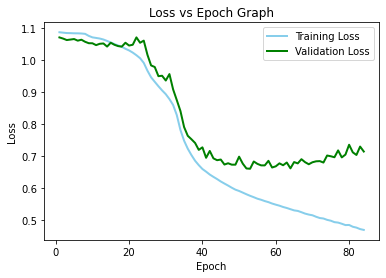

In [ ]:
# multiple line plots
plt.plot(epoch_list, loss_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_loss_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Graph')
plt.legend(['Training Loss', 'Validation Loss'])

plt.savefig('./output/FI-2010 Loss Graph.png')
plt.show()

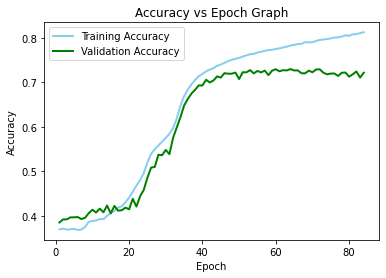

In [ ]:
# multiple line plots
plt.plot(epoch_list, accuracy_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_accuracy_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.savefig('./output/FI-2010 Accuracy Graph.png')
plt.show()

In [ ]:
JNJ_lines = open('./output/JNJ-training-process.txt', 'r').readlines()
loss_value_list = []
accuracy_value_list = []
val_loss_value_list = []
val_accuracy_value_list = []
for i in range(len(JNJ_lines)):
    line = JNJ_lines[i]
    str_list = np.array(line.split(' '))
    if i % 2 == 1:
        loss_i = np.where(str_list == 'loss:')[0][0]
        loss_value = float(str_list[loss_i + 1])
        accuracy_i = np.where(str_list == 'accuracy:')[0][0]
        accuracy_value = float(str_list[accuracy_i + 1])
        val_loss_i = np.where(str_list == 'val_loss:')[0][0]
        val_loss_value = float(str_list[val_loss_i + 1])
        val_accuracy_i = np.where(str_list == 'val_accuracy:')[0][0]
        val_accuracy_value = float(str_list[val_accuracy_i + 1])

        loss_value_list.append(loss_value)
        accuracy_value_list.append(accuracy_value)
        val_loss_value_list.append(val_loss_value)
        val_accuracy_value_list.append(val_accuracy_value)
epoch_list = list(range(1,len(loss_value_list)+1))

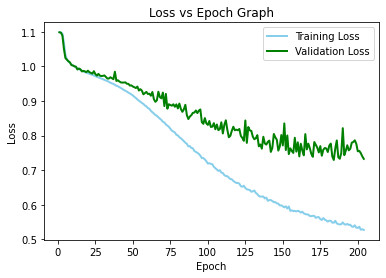

In [ ]:
# multiple line plots
plt.plot(epoch_list, loss_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_loss_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Graph')
plt.legend(['Training Loss', 'Validation Loss'])

plt.savefig('./output/JNJ Loss Graph.png')
plt.show()

In [ ]:
# multiple line plots
plt.plot(epoch_list, accuracy_value_list, color='skyblue', linewidth=2)
plt.plot(epoch_list, val_accuracy_value_list, color='green', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.savefig('./output/JNJ Accuracy Graph.png')
plt.show()